In [1]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.utils.env_checker import check_env

# Maak de custom gymnasium omgeving

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

import pygame
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

class SnakeEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

######################################################################################################
    def __init__(self, render_mode=None):
        super(SnakeEnv, self).__init__()
        self.grid_size = 20
        self.cell_size = 30
        self.action_space = spaces.Discrete(4)  # 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.observation_space = spaces.Box(low=0, high=1,
                                            shape=(self.grid_size, self.grid_size), dtype=np.int32)
        self.render_mode = render_mode
        self.window = None
        self.clock = None
##########################################################################################################


    def reset(self, seed=None, options=None):
        self.snake = [(5, 5), (5, 5), (5, 5)]
        self.direction = 1
        self.food = self._place_food()
        self.done = False
        if self.render_mode == "human":
            self._init_render()
        return self._get_obs(), {}

    def _place_food(self):
        while True:
            food = (random.randint(0, 9), random.randint(0, 9))
            if food not in self.snake:
                return food
#####################################################################################
    def _get_obs(self):
        obs = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)

        for x, y in self.snake[1:]:
            obs[y][x] = 1  # Body
        
        head_x, head_y = self.snake[0]
        obs[head_y][head_x] = 3  # 👈 Mark head as 3

        fx, fy = self.food
        obs[fy][fx] = 2  # Food is still 2

        return obs



    def step(self, action):
        if self.done:
            return self._get_obs(), 0, True, False, {}

        if abs(action - self.direction) == 2:
            action = self.direction

        self.direction = action

        dx = [0, 1, 0, -1]
        dy = [-1, 0, 1, 0]
        head_x, head_y = self.snake[0]
        new_head = (head_x + dx[action], head_y + dy[action])

        if (new_head in self.snake or
            not 0 <= new_head[0] < self.grid_size or
            not 0 <= new_head[1] < self.grid_size):
            self.done = True
            return self._get_obs(), -10, True, False, {}

        self.snake.insert(0, new_head)
##############################################################################
        fx, fy = self.food
        old_dist = abs(head_x - fx) + abs(head_y - fy)
        new_dist = abs(new_head[0] - fx) + abs(new_head[1] - fy)

        self.steps = 0
        self.steps += 1

        if new_head == self.food:
            reward = 50
            self.food = self._place_food()
            self.steps = 0  
        else:
            reward = (old_dist - new_dist) * 0.5 - 0.2
            self.snake.pop()

        if self.steps >= 100:
            reward= -10
            self.done = True
            return self._get_obs(), reward, True, False, {}

###################################################################################
#        if new_head == self.food:
#            reward = 10
#            self.food = self._place_food()
#        else:
#            reward = -0.1
#            self.snake.pop()
###############################################################################
        if self.render_mode == "human":
            self.render()
            

        return self._get_obs(), reward, False, False, {}

    def _init_render(self):
        pygame.init()
        self.window = pygame.display.set_mode(
            (self.grid_size * self.cell_size, self.grid_size * self.cell_size))
        pygame.display.set_caption("Snake AI")
        self.clock = pygame.time.Clock()

    def render(self):
        if self.window is None:
            self._init_render()

        self.window.fill((0, 0, 0))
        for x, y in self.snake:
            pygame.draw.rect(
                self.window,
                (0, 255, 0),
                pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            )

        fx, fy = self.food
        pygame.draw.rect(
            self.window,
            (255, 0, 0),
            pygame.Rect(fx * self.cell_size, fy * self.cell_size, self.cell_size, self.cell_size)
        )

        pygame.display.flip()
        self.clock.tick(10)

    def close(self):
        if self.window:
            pygame.quit()


In [5]:
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym

from stable_baselines3.common.callbacks import BaseCallback

class EvalAndRenderCallback(BaseCallback):
    def __init__(self, eval_env, render_freq=10_000, verbose=0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.render_freq = render_freq
        self.episodes_run = 0

    def _on_step(self) -> bool:
        if self.num_timesteps % self.render_freq == 0:
            obs, _ = self.eval_env.reset()
            done = False
            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, done, truncated, info = self.eval_env.step(action)
                self.eval_env.render()
        return True


# Maak een instance van je custom omgeving
env = SnakeEnv(render_mode=None)

# Check of alles compatibel is
#check_env(env)

# Wrap de omgeving (nodig voor Stable-Baselines3)
vec_env = DummyVecEnv([lambda: SnakeEnv(render_mode=None)])

# Initialiseer PPO
#model = PPO("MlpPolicy", vec_env, verbose=1, learning_rate=1e-4, n_steps=2048, batch_size=64, n_epochs=10,
#    tensorboard_log="./ppo_snake_tensorboard/",device='cpu')
model = DQN("MlpPolicy", env, verbose=1)
eval_env = SnakeEnv(render_mode="human")
callback = EvalAndRenderCallback(eval_env=eval_env, render_freq=1000)

model.learn(total_timesteps=2000_000, callback=None)


model.save("DQN_snake_head2M")
# Om later opnieuw te laden:
# model = PPO.load("ppo_snake")

test_env = SnakeEnv(render_mode="human")
obs, _ = test_env.reset()
done = False

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, truncated, info = test_env.step(action)
    test_env.render()

test_env.close()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.2     |
|    ep_rew_mean      | -6.35    |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 13624    |
|    time_elapsed     | 0        |
|    total_timesteps  | 97       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 775      |
|    time_elapsed     | 0        |
|    total_timesteps  | 231      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 32       |
------------------------------

In [6]:
from stable_baselines3 import PPO

# Recreate the environment (no training wrapper needed)
eval_env = SnakeEnv(render_mode="human")  # enable rendering

# Load your trained model
model = PPO.load("ppo_snake_timeframe_10M", env=eval_env,device='cpu')


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
from stable_baselines3 import PPO

# Recreate the environment (no training wrapper needed)
eval_env = SnakeEnv(render_mode="human")  # enable rendering

# Load your trained model
model = PPO.load("ppo_snake_timeframe_10M", env=eval_env,device='cpu')


num_episodes = 20
max_steps = 200  # Max steps allowed without eating
total_rewards = []
food_eaten=0

for _ in range(num_episodes):
    obs, _ = eval_env.reset()
    done = False
    episode_reward = 0
    steps_since_last_food = 0
    

    while not done and steps_since_last_food < max_steps:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = eval_env.step(action)
        episode_reward += reward

        if reward >= 50:  # Assumes 50 is your apple-eaten reward
            steps_since_last_food = 0  # 👈 Reset step timer when food is eaten
            food_eaten += 1
        else:
            steps_since_last_food += 1

    total_rewards.append(episode_reward)

avg_reward = sum(total_rewards) / len(total_rewards)
avg_food = food_eaten/num_episodes
print(f"Average reward over {num_episodes} episodes: {avg_reward} food eaten:{avg_food}")



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Average reward over 20 episodes: 177.1500000000005 food eaten:3.95


In [6]:
import time
import numpy as np
from stable_baselines3 import PPO

# Recreate the environment (no training wrapper needed)
eval_env = SnakeEnv(render_mode="human")  # enable rendering

# Load your trained model
model_path = "DQN_snake_head2M"
model = DQN.load(model_path, env=eval_env,device='cpu')

num_episodes = 20
total_rewards = []
food_counts = []

highscore = 0

for episode in range(num_episodes):
    obs, _ = eval_env.reset()
    done = False
    episode_reward = 0
    step_count = 0
    food_eaten = 0
    steps_since_food = 0  


    while not done:
        action, _ = model.predict(obs, deterministic=True)
        prev_snake_len = len(eval_env.snake)

        obs, reward, done, truncated, info = eval_env.step(action)
        episode_reward += reward
        step_count += 1
        steps_since_food += 1  # tel stappen sinds laatste appel

        # Check of voedsel is gegeten
        if len(eval_env.snake) > prev_snake_len:
            food_eaten += 1
            steps_since_food = 0  # reset bij eten

        # Stop als er 200 stappen geen voedsel is gegeten
        if steps_since_food >= 200:
            print("⚠️  Terminating: no food eaten in 200 steps.")
            break

        time.sleep(0.1)


    total_rewards.append(episode_reward)
    food_counts.append(food_eaten)
    highscore = max(highscore, food_eaten)

    print(f"\n✅ Episode {episode+1} finished.")
    print(f"🔸 Reward: {episode_reward:.2f}")
    print(f"🍎 Food eaten: {food_eaten}")
    print(f"🏆 Highscore so far: {highscore}")

# Na alle episodes
avg_reward = sum(total_rewards) / len(total_rewards)
avg_food = sum(food_counts) / len(food_counts)

print("\n==== Test Summary ====")
print(f"Average reward: {avg_reward:.2f}")
print(f"Average food per episode: {avg_food:.2f}")
print(f"Highscore (most food): {highscore}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

✅ Episode 1 finished.
🔸 Reward: 43.30
🍎 Food eaten: 1
🏆 Highscore so far: 1

✅ Episode 2 finished.
🔸 Reward: 33.10
🍎 Food eaten: 1
🏆 Highscore so far: 1

✅ Episode 3 finished.
🔸 Reward: 36.30
🍎 Food eaten: 1
🏆 Highscore so far: 1
⚠️  Terminating: no food eaten in 200 steps.

✅ Episode 4 finished.
🔸 Reward: 10.70
🍎 Food eaten: 1
🏆 Highscore so far: 1

✅ Episode 5 finished.
🔸 Reward: 139.90
🍎 Food eaten: 3
🏆 Highscore so far: 3

✅ Episode 6 finished.
🔸 Reward: 83.50
🍎 Food eaten: 2
🏆 Highscore so far: 3

✅ Episode 7 finished.
🔸 Reward: 37.50
🍎 Food eaten: 1
🏆 Highscore so far: 3

✅ Episode 8 finished.
🔸 Reward: 27.30
🍎 Food eaten: 1
🏆 Highscore so far: 3

✅ Episode 9 finished.
🔸 Reward: 35.80
🍎 Food eaten: 1
🏆 Highscore so far: 3

✅ Episode 10 finished.
🔸 Reward: -11.80
🍎 Food eaten: 0
🏆 Highscore so far: 3

✅ Episode 11 finished.
🔸 Reward: 79.60
🍎 Food eaten: 2
🏆 Highscore so far: 3
⚠️  Terminating: no food ea

In [20]:
import matplotlib.pyplot as plt

def test_model_with_plot(model, eval_env, num_episodes=20, render=False, max_steps_per_episode=300):

    total_rewards = []
    total_steps = []
    apples_per_episode = []

    best_score = float('-inf')  # Voor highscore

    for episode in range(num_episodes):
        obs, _ = eval_env.reset()
        done = False
        episode_reward = 0
        step_count = 0
        apples_eaten = 0
        prev_snake_len = len(eval_env.snake)

        while not done and step_count < max_steps_per_episode:
            if render:
                eval_env.render()

            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = eval_env.step(action)
            step_count += 1
            episode_reward += reward

            # Tel appel als lengte toeneemt
            current_snake_len = len(eval_env.snake)
            if current_snake_len > prev_snake_len:
                apples_eaten += 1
            prev_snake_len = current_snake_len

        total_rewards.append(episode_reward)
        total_steps.append(step_count)
        apples_per_episode.append(apples_eaten)

        
        if episode_reward > best_score:
            best_score = episode_reward

        print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, Steps = {step_count}, Apples = {apples_eaten}")

    avg_reward = sum(total_rewards) / num_episodes
    avg_steps = sum(total_steps) / num_episodes
    total_apples = sum(apples_per_episode)
    highest_apples = max(apples_per_episode)

    print("\n=== Test Summary ===")
    print(f"Average Reward per Episode: {avg_reward:.2f}")
    print(f"Average Steps until Death: {avg_steps:.2f}")
    print(f"Total Apples Eaten: {total_apples}")
    print(f"High Score (Best Reward): {best_score:.2f}")
    print(f"High Apple Score (Best Reward): {highest_apples:.2f}")

    # === Plot ===
    episodes = list(range(1, num_episodes + 1))
    plt.figure(figsize=(12, 6))

    plt.plot(episodes, total_rewards, label='Reward per Episode', color='blue')
    plt.plot(episodes, total_steps, label='Steps per Episode', color='green')
    plt.plot(episodes, apples_per_episode, label='Apples Eaten', color='red')

    plt.title('Model Performance per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1: Reward = 77.30, Steps = 74, Apples = 2
Episode 2: Reward = -4.30, Steps = 300, Apples = 1
Episode 3: Reward = -11.80, Steps = 15, Apples = 0
Episode 4: Reward = -9.50, Steps = 6, Apples = 0
Episode 5: Reward = -59.00, Steps = 300, Apples = 0
Episode 6: Reward = 44.40, Steps = 300, Apples = 2
Episode 7: Reward = -9.50, Steps = 6, Apples = 0
Episode 8: Reward = 50.40, Steps = 300, Apples = 2
Episode 9: Reward = -3.30, Steps = 300, Apples = 1
Episode 10: Reward = -7.30, Steps = 300, Apples = 1
Episode 11: Reward = 48.40, Steps = 300, Apples = 2
Episode 12: Reward = 86.20, Steps = 37, Apples = 2
Episode 13: Reward = 38.10, Steps = 29, Apples = 1
Episode 14: Reward = 234.60, Steps = 128, Apples = 5
Episode 15: Reward = 101.10, Steps = 300, Apples = 3
Episode 16: Reward = 149.10, Steps = 41, Apples = 3
Episode 17: Reward = 188.40, Steps = 63, Apples = 4
Episode 18: Reward = 140.80, Steps = 40, Apples = 3


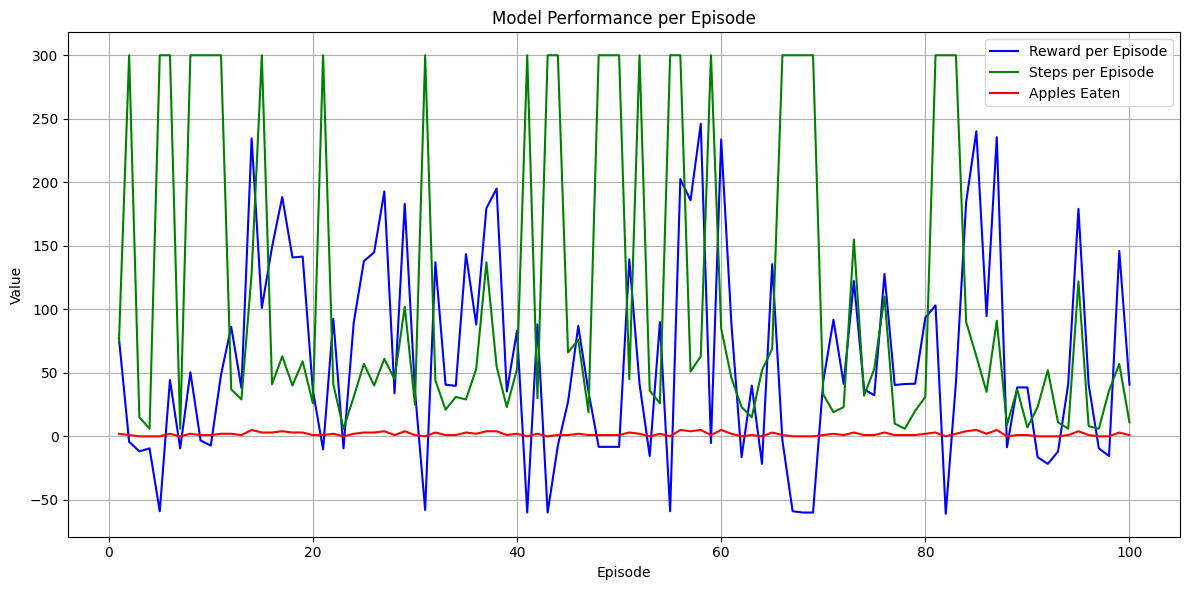

In [21]:
model_path = "DQN_snake_head2M"
eval_env = SnakeEnv(render_mode=None)
model = DQN.load(model_path, env=eval_env,device='cpu')
test_model_with_plot(model, eval_env, num_episodes=100, render=False)


# Registreer de omgeving

In [ ]:
%tensorboard --logdir='ppo_snake_tensorboard'
%reload_ext tensorboard

Reusing TensorBoard on port 6007 (pid 16380), started 0:00:50 ago. (Use '!kill 16380' to kill it.)

: 